# Проект: Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Необходимо построить модель, которая по фотографии определит приблизительный возраст человека. 

В распоряжении есть набор фотографий людей и датафрейм в котором указаны:
- имя файла `file_name`; 
- возраст `real_age`.

Проект будет состоять из нескольких блоков:
<div class="toc"><ul class="toc-item"><li><span><a href="#Исследовательский-анализ-данных" data-toc-modified-id="Исследовательский анализ данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Исследовательский анализ данных</a></span><ul class="toc-item"><li><span><a href="#Загрузка-данных-и-изучение-общей-информации" data-toc-modified-id="Загрузка-данных-и-изучение-общей-информации-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Загрузка данных и изучение общей информации</a></span></li><li><span><a href="#Исследовательский-анализ" data-toc-modified-id="Исследовательский-анализ-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Исследовательский анализ</a></span></li></ul></li><li><span><a href="#Обучение-модели" data-toc-modified-id="/Обучение-модели-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение модели</a></span></li><li><span><a href="#Анализ-обученной-модели" data-toc-modified-id="Анализ-обученной-модели-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ обученной модели</a></span></li><li><span><a href="#Чек-лист" data-toc-modified-id="Чек-лист-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист</a></span></li></ul></div>

## Исследовательский анализ данных

### Загрузка данных и изучение общей информации

Импортируем все необходимые для выполнения проекта библиотеки:

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

Загрузим данные с названиями файлов `file_name` и целевым признаком `real_age`:

In [2]:
# путь к датафрейму labels в тренажере
pth = '/datasets/faces/labels.csv'

# считываем данные и сохраняем в переменную labels
if os.path.exists(pth):
    labels = pd.read_csv(pth)
else:
    print('Something is wrong')

In [3]:
# выводим первые 10 строк labels
labels.head(10)

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
5,000005.jpg,27
6,000006.jpg,24
7,000007.jpg,43
8,000008.jpg,26
9,000009.jpg,39


Посмотрим на иформацию о датафрейме с помощью методов `info` и `describe`:

In [4]:
# информация о датафрейме
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [5]:
# информация о датафрейме
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


В нашем распоряжении 7591 наименование изображений, без пропусков, с диапазоном возрастов от года до ста лет.

### Исследовательский анализ

Посмотрим на распределение целевого признака `real_age`:

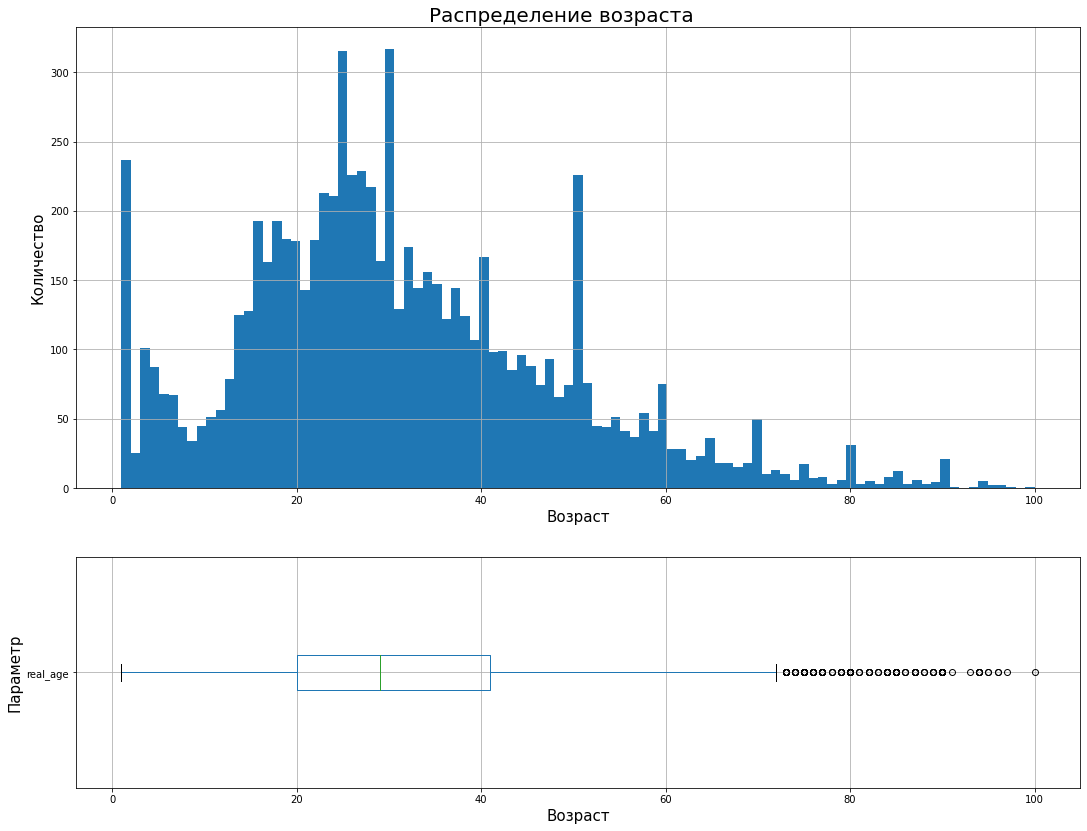

In [6]:
# построение фигур для графиков
fig, axes = plt.subplots(2, 1, figsize=(18, 14), gridspec_kw={'height_ratios': [2, 1]})
plt.suptitle('Распределение возраста', fontsize=20, y=0.9)
    
# построение гистограммы
labels['real_age'].hist(bins=labels['real_age'].nunique(), grid=True, ax=axes[0])
axes[0].set_ylabel('Количество', fontsize=15)
axes[0].set_xlabel('Возраст', fontsize=15)
        
# построение ящика с усами
labels.boxplot(column='real_age', ax=axes[1], vert=False, figsize=(18, 5))
axes[1].set_ylabel('Параметр', fontsize=15)
axes[1].set_xlabel('Возраст', fontsize=15)
    
plt.show()

Можно сделать следующие выводы:
- в основном возраст на фото от года до 70 лет, и совсем немного есть фото, где люди старше 70 лет;
- много фото с годовалыми детьми порядка 235 фото;
- много ярко выраженных пиков на круглых возрастах: 25, 30, 40, 50, 60, 70, 80 и 90 лет;
- есть провал в районе 10-летних;
- средний возраст (31,2) больше медианного возраста 29;
- распределение нельзя назвать нормальным.

Теперь посмотрим на сами фотографии:

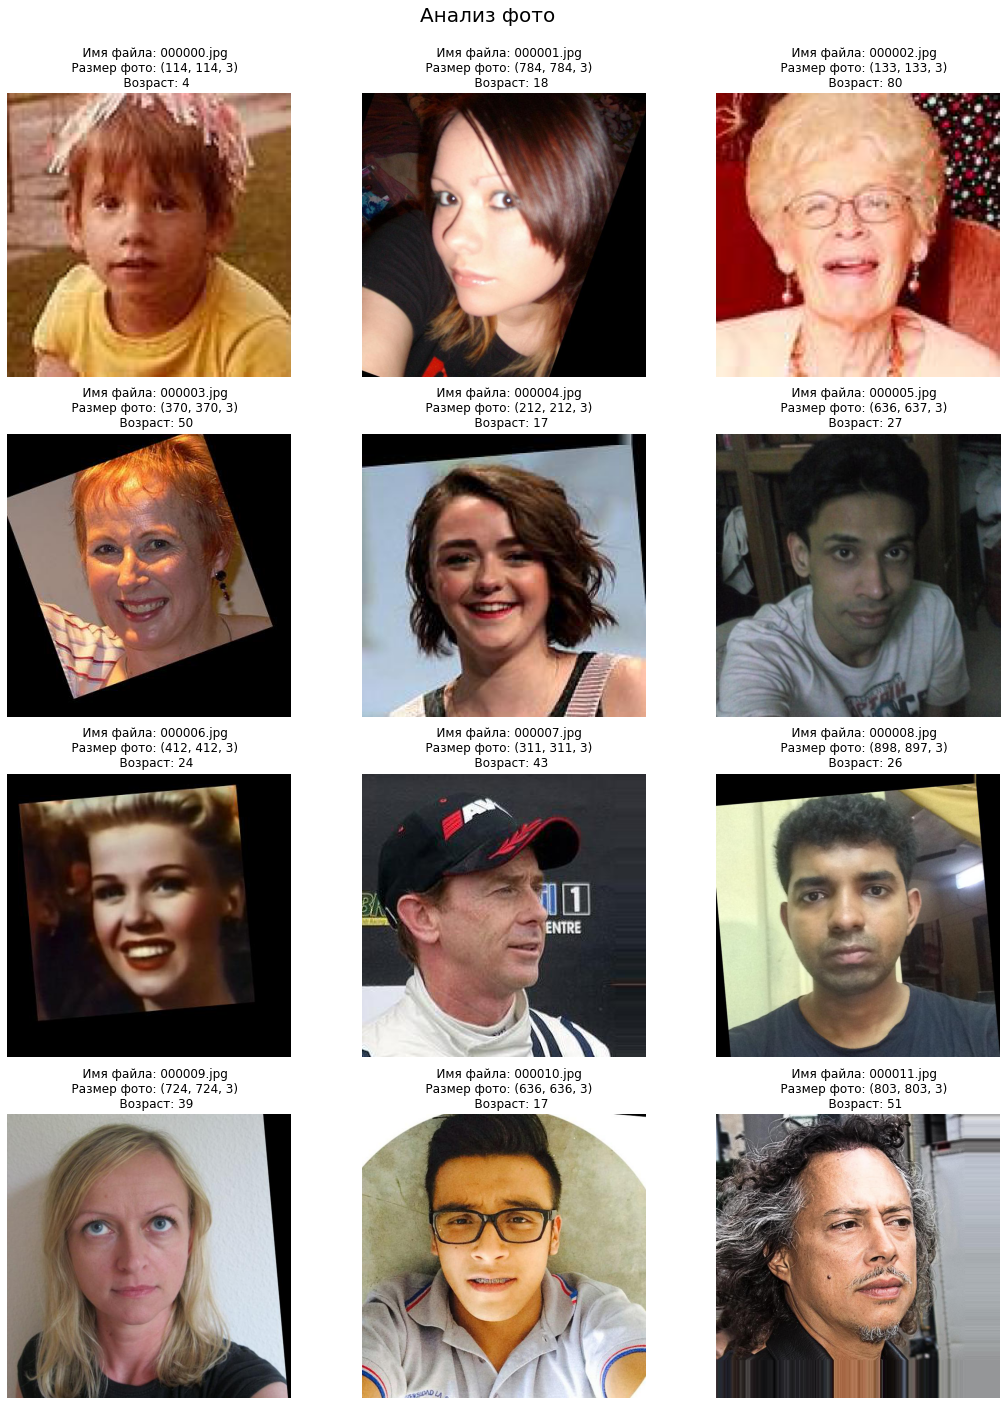

In [7]:
# построение фигур для графиков
fig, axes = plt.subplots(4, 3, figsize=(18, 24))
plt.suptitle('Анализ фото', fontsize=20, y=0.93)

# вывод фото, информации и фозраста
for i in range(12):
    # индексы для позиционирования
    a = i // 3
    b = i % 3
    
    # загрузка фото
    image = Image.open('/datasets/faces/final_files/' + str(labels['file_name'].iloc[i]))
    
    
    axes[a, b].imshow(np.array(image))
    axes[a, b].set_title(f'''
    Имя файла: {str(labels["file_name"].iloc[i])} 
    Размер фото: {np.array(image).shape} 
    Возраст: {str(labels["real_age"].iloc[i])}
    ''', y=0.95)
    axes[a, b].axis('off')

plt.show()

По фотографиям видно, что:
- формат фото - `jpg`;
- на фото три цветовых канала `RGB`;
- размер у всех фотографий разный, поэтому при загрузке данных при вызове функции `flow_from_dataframe` необходимо будет привести изображения к одному размеру, т.к. нейронным сетям нужно, чтобы все изображения были одинаковые;
- на фото представлены как мужчины так и женщины разных возрастов, который соответствует фото;
- на фото лица позиционнированны по середине, некоторые даже повернуты, из-за чего появился черный фон по краям, на фото `000011.jpg` есть шлейф из пикселей нижнего края фото.

Вывод по блоку:
- в распоряжении датасет из 7591 фото, с людьми с возрастом от года до 100 лет;
- формат фото - `jpg` с тремя цветовыми каналами, размеры фото разный;
- все лица на фото отцентрованы.

## Обучение модели

Ниже представлен код, который запускался в отдельном GPU-тренажёре, который содержит:
- функции `load_train` и `load_test`, которые выгружают тренировочные и тестовые данные через загрузчик;
- функцию `create_model`, которая определяет модель `ResNet50`;
- функцию `train_model`, которая обучает модель.

```python

import pandas as pd
import numpy as np

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.applications.resnet import ResNet50
 
def load_train(path):
    
    train_datagen = ImageDataGenerator(rescale=1/255., 
                                       validation_split=0.25, 
                                       rotation_range=15)
    
    train_gen_flow = train_datagen.flow_from_dataframe(dataframe=pd.read_csv(path + 'labels.csv'), 
                                                       directory=path + 'final_files/', 
                                                       x_col='file_name', 
                                                       y_col='real_age', 
                                                       target_size=(224, 224), 
                                                       batch_size=32, 
                                                       class_mode='raw', 
                                                       subset='training', 
                                                       seed=12345) 
    
    return train_gen_flow

def load_test(path):
    
    test_datagen = ImageDataGenerator(rescale=1/255., 
                                      validation_split=0.25)
    
    test_gen_flow = test_datagen.flow_from_dataframe(dataframe=pd.read_csv(path + 'labels.csv'), 
                                                     directory=path + 'final_files/', 
                                                     x_col='file_name', 
                                                     y_col='real_age', 
                                                     target_size=(224, 224), 
                                                     batch_size=32, 
                                                     class_mode='raw', 
                                                     subset='validation', 
                                                     seed=12345) 
    
    return test_gen_flow

def create_model(input_shape):
   
    backbone = ResNet50(input_shape=input_shape,
                        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', 
                        include_top=False)
    
    model = Sequential()    
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 

    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_absolute_error'])
    
    return model
 
def train_model(model, train_data, test_data, batch_size=None, epochs=15, steps_per_epoch=None, validation_steps=None):
     
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if steps_per_epoch is None:
        validation_steps = len(test_data)

    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2,
              shuffle=True)
 
    return model

```

Ниже представлен вывод тренажера:

```

Found 5694 validated image filenames.
Found 1897 validated image filenames.

<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 178 steps, validate for 60 steps
Epoch 1/15
178/178 - 116s - loss: 261.0026 - mean_absolute_error: 11.5604 - val_loss: 733.6692 - val_mean_absolute_error: 22.1563
Epoch 2/15
178/178 - 90s - loss: 82.0050 - mean_absolute_error: 6.8214 - val_loss: 743.8237 - val_mean_absolute_error: 22.2808
Epoch 3/15
178/178 - 90s - loss: 52.9497 - mean_absolute_error: 5.5629 - val_loss: 465.5661 - val_mean_absolute_error: 16.5091
Epoch 4/15
178/178 - 90s - loss: 40.3532 - mean_absolute_error: 4.8906 - val_loss: 150.4761 - val_mean_absolute_error: 8.8731
Epoch 5/15
178/178 - 90s - loss: 30.3317 - mean_absolute_error: 4.3015 - val_loss: 84.8256 - val_mean_absolute_error: 6.8940
Epoch 6/15
178/178 - 90s - loss: 25.9966 - mean_absolute_error: 3.9104 - val_loss: 76.8495 - val_mean_absolute_error: 6.6244
Epoch 7/15
178/178 - 90s - loss: 21.4108 - mean_absolute_error: 3.5783 - val_loss: 71.3189 - val_mean_absolute_error: 6.4462
Epoch 8/15
178/178 - 90s - loss: 18.1589 - mean_absolute_error: 3.2850 - val_loss: 72.7752 - val_mean_absolute_error: 6.5496
Epoch 9/15
178/178 - 90s - loss: 16.2724 - mean_absolute_error: 3.1005 - val_loss: 70.8377 - val_mean_absolute_error: 6.2041
Epoch 10/15
178/178 - 90s - loss: 13.4826 - mean_absolute_error: 2.8069 - val_loss: 77.7839 - val_mean_absolute_error: 6.4702
Epoch 11/15
178/178 - 90s - loss: 12.4166 - mean_absolute_error: 2.6995 - val_loss: 64.1626 - val_mean_absolute_error: 6.0958
Epoch 12/15
178/178 - 90s - loss: 10.0034 - mean_absolute_error: 2.4433 - val_loss: 67.3986 - val_mean_absolute_error: 6.0673
Epoch 13/15
178/178 - 90s - loss: 9.4926 - mean_absolute_error: 2.3441 - val_loss: 64.9892 - val_mean_absolute_error: 6.0314
Epoch 14/15
178/178 - 90s - loss: 8.7678 - mean_absolute_error: 2.2579 - val_loss: 64.0548 - val_mean_absolute_error: 5.8851
Epoch 15/15
178/178 - 89s - loss: 8.1344 - mean_absolute_error: 2.1728 - val_loss: 62.8518 - val_mean_absolute_error: 5.8894
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 10s - loss: 62.8518 - mean_absolute_error: 5.8894
Test MAE: 5.8894


```

Значение `MAE` на тестовой выборке получилась - **5,8894**, что удовлетворяет условию заказчика (значение `MAE`не больше 8).

## Анализ обученной модели

В данном проекте для предсказания по фотографии приблизительного возраста человека была использована нейросеть `ResNet50` с параметрами:
- для сокращения времени выполнения кода в параметре `weights` был указан путь к загруженным весам модели `ResNet50`;
- `include_top=False` - чтобы убрать последние два слоя: `GlobalAveragePooling2D` и `Dense`, они были добавлены в ручную, т.к. на выходе нужен один нейрон, предсказывающий возраст с активацией `relu`, чтобы исключить отрицательные выводы сети;
- в качестве оптимизатора был выбран алгоритм `Adam`, со скоростью обучения - 0,0001;
- заморозка весов не применялась.

При обучении модели `ResNet50` были использованы следующие параметры:
- `batch_size` - без ограничений;
- `epochs` - количество эпох - 15;
- `steps_per_epoch` и `validation_steps` - были сформированы по размеру тренировочной и тестовой выборке соответственно.

Результат `MAE` на тестовой выборке получился **5,8894**, это говорит о том, что эта модель ошибается в среднем на 6 лет, на тренировочной выборке `MAE` -  2,1728 почти в три раз меньше, что может говорить о том, что модель переобучилась.

Метрика `MAE` удовлетворяет условию заказчика, но в абсолютном значении шесть лет это много, это скорее всего связано с тем, что в представленном датасете мало данных о возрастных людях и не так много о детях в районе 8-12 лет и нейросети возможно не зватило этих данных для более точных предсказаний. 